In [108]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [109]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [110]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
from sqlalchemy import func

In [111]:
# create engine to hawaii.sqlite
Engine = create_engine("sqlite:///../sqlalchemy_challenge/Resources/hawaii.sqlite")

In [112]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(Engine, reflect = True)

In [113]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [114]:
# Inspect for more detail
inspector = inspect(Engine)
inspector.get_table_names()
# Inspector to get column name and types --- measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [115]:
# Inspector to get column name and types --- station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [116]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [117]:
# Create our session (link) from Python to the DB
session = Session(Engine)

# Exploratory Precipitation Analysis

In [118]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

'2017-08-23'

Text(0.5, 0, 'Date')

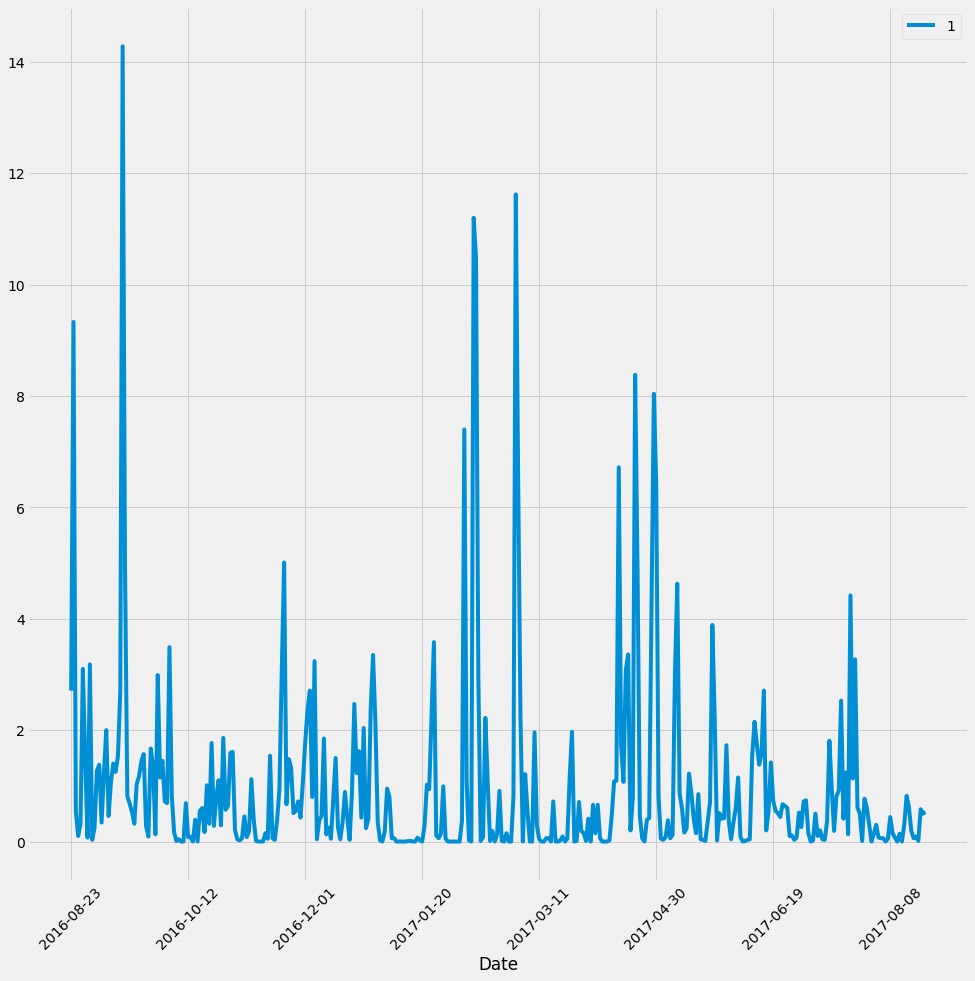

In [119]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(measurement.date,func.sum(measurement.prcp)).filter(measurement.date >= year_ago).group_by(measurement.date).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df1 = pd.DataFrame(prcp).set_index(0)
df1.head()

# Use Pandas Plotting with Matplotlib to plot the data
df1.plot(figsize = (15,15),rot =45)
plt.xlabel('Date')

In [120]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df1.describe()

,1
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [121]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [122]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [123]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
three_query = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]

most_active_stations = session.query(*three_query).filter(measurement.station == 'USC00519281').all()

most_active_stations


[(54.0, 85.0, 71.66378066378067)]

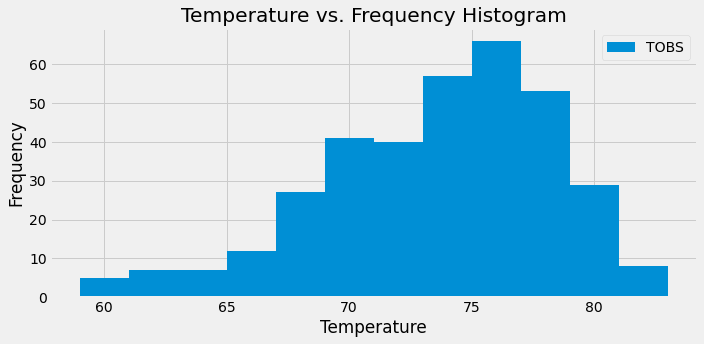

In [124]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_most_active_station = session.query(measurement.tobs).filter(measurement.date >= year_ago).filter(measurement.station == 'USC00519281').order_by(measurement.date).all()

temp_most_active_station_df = pd.DataFrame(temp_most_active_station, columns=['TOBS'])

temp_most_active_station_df.plot.hist(bins=12, title='Temperature vs. Frequency Histogram', figsize=(10,5))
plt.xlabel('Temperature')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('station_histogram.png')
plt.show()

# Close session

In [125]:
# Close Session
session.close()